In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm.auto import tqdm

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
IMAGE_LIB = 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/*.png'
MASK_LIB = 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/mask_mura/*.png'

IMG_SIZEx = 456
IMG_SIZEy = 256
# SEED = 5566
NUM_CLASSES = 4
print(sorted(glob(IMAGE_LIB)))
print(glob(IMAGE_LIB))

['drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg1.png', 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg2.png', 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg3.png', 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg4.png', 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg5.png']
['drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg1.png', 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg2.png', 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg3.png', 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg4.png', 'drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_se

# Data

In [ ]:
img_paths = sorted(glob(IMAGE_LIB))
mask_paths = sorted(glob(MASK_LIB))

x_data = np.empty((len(img_paths), IMG_SIZEy, IMG_SIZEx))
y_data = np.empty((len(img_paths), IMG_SIZEy, IMG_SIZEx, NUM_CLASSES))
print(len(x_data[0][0]))

456


In [ ]:
img_paths = sorted(glob(IMAGE_LIB))
mask_paths = sorted(glob(MASK_LIB))

x_data = np.empty((len(img_paths), IMG_SIZEy, IMG_SIZEx))
y_data = np.empty((len(img_paths), IMG_SIZEy, IMG_SIZEx, NUM_CLASSES))

for i, path in enumerate(tqdm(img_paths)):
    print(path)
    # read input image
    img = cv2.imread(path)[:,:,0] # get channel 0 since it's a gray scale image
    img = cv2.resize(img, (IMG_SIZEx, IMG_SIZEy))
    img = img / 255.
    x_data[i] = img
    filename_img = os.path.split(path)[1] # filename_img: seg1.png
    filename = filename_img.split('.')[0] # filename: seg1
    print(filename_img)
    print(filename)
    # read mask image
    for j in range(NUM_CLASSES):
        mask = cv2.imread(os.path.join('drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/mask_mura', f'{filename}_mask_{j}.png'))[:,:,0] # seg1_mask_0.png, seg1_mask_1.png, seg1_mask_2.png
        mask = mask / 255.
        mask[mask>=0.5] = 1.
        mask[mask<0.5] = 0
        mask = cv2.resize(mask, (IMG_SIZEx, IMG_SIZEy))
        y_data[i, :, :, j] = mask


drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg1.png
seg1.png
seg1
drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg2.png
seg2.png
seg2
drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg3.png
seg3.png
seg3
drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg4.png
seg4.png
seg4
drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/img_mura/seg5.png
seg5.png
seg5



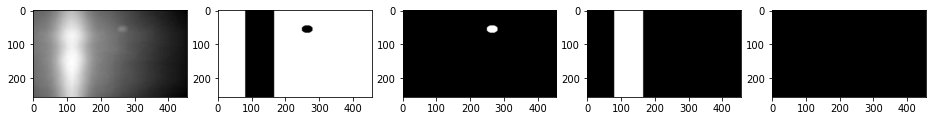

In [ ]:
fig, ax = plt.subplots(1,5, figsize = (16,4))
ax[0].imshow(x_data[4], cmap='gray')#cmap='gray'
ax[1].imshow(y_data[4, :, :, 0], cmap='gray')
ax[2].imshow(y_data[4, :, :, 1], cmap='gray')
ax[3].imshow(y_data[4, :, :, 2], cmap='gray')
ax[4].imshow(y_data[4, :, :, 3], cmap='gray')
plt.show()
# print(x_data[0])
# print("=============")
# print(y_data[0])

In [ ]:
x_data.shape, y_data.shape

((5, 256, 456), (5, 256, 456, 4))

In [ ]:
x_data = np.expand_dims(x_data, axis=-1)#如果是3pixel 那就不需要了
x_data.shape, y_data.shape

((5, 256, 456, 1), (5, 256, 456, 4))

# Model

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 456, 1) 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 456, 16) 160         input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 256, 456, 16) 2320        conv2d_135[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 128, 228, 16) 0           conv2d_136[0][0]                 
______________________________________________________________________________________

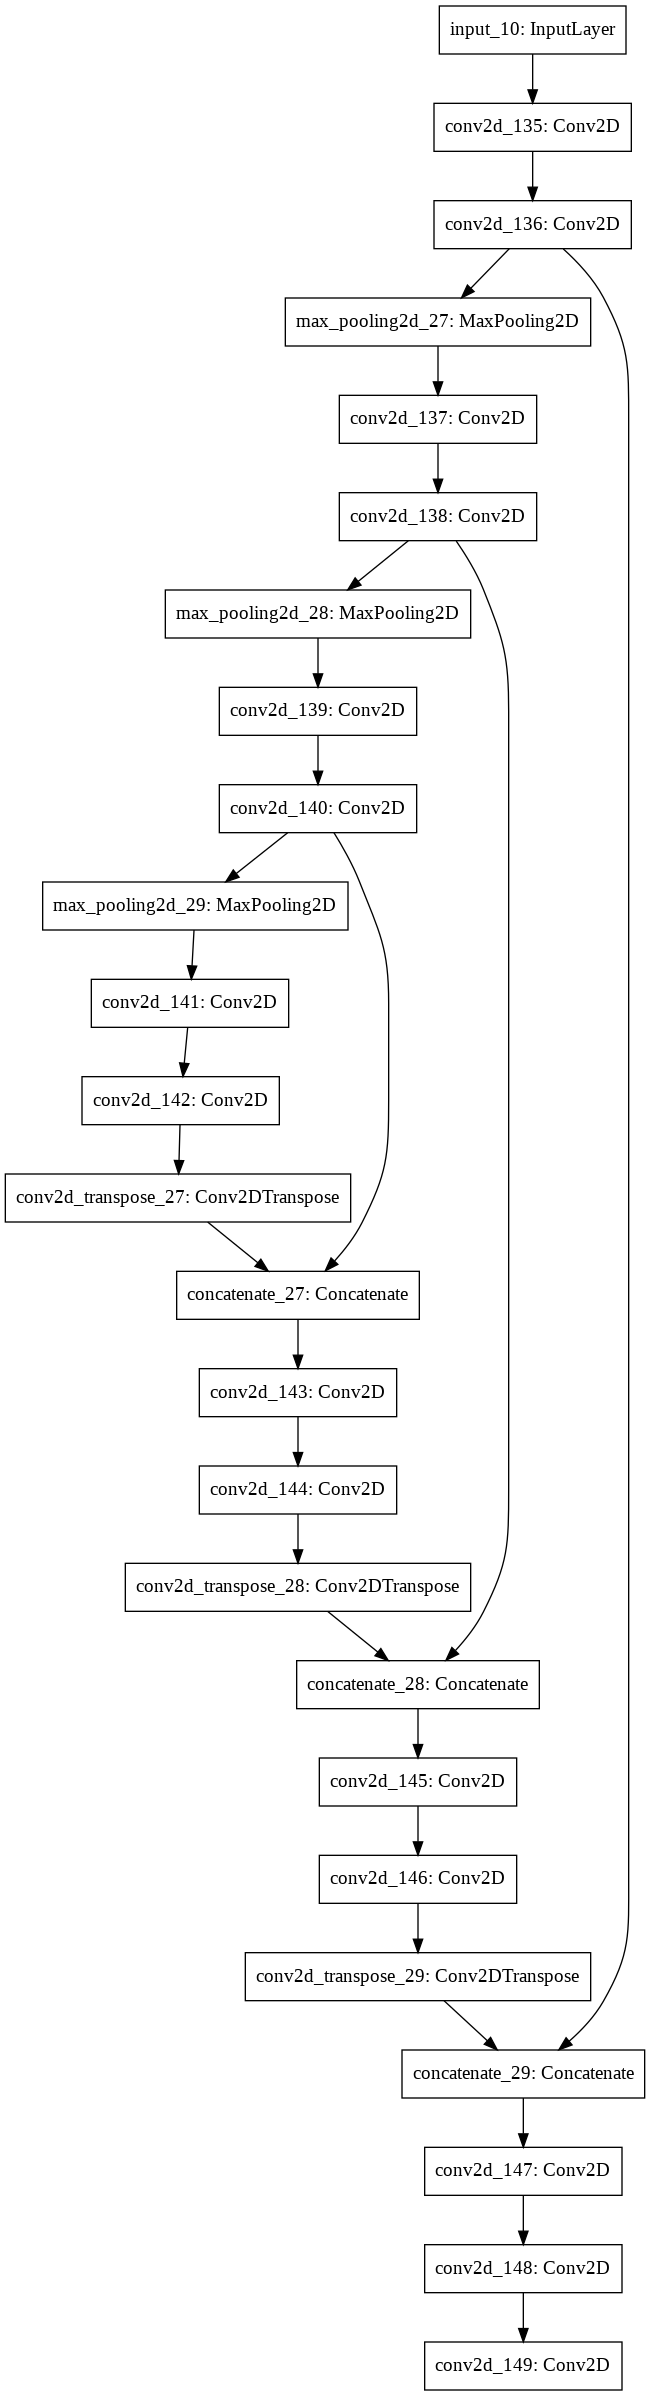

In [ ]:
# Unet with Conv2DTranspose
import matplotlib.pyplot as plt
input_layer = Input(shape=(IMG_SIZEy, IMG_SIZEx, 1))
l = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
c1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c1)
l = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
c3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
c4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4), c3], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l), c2], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l), c1], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
output_layer = Conv2D(filters=4, kernel_size=(1,1), activation='softmax')(l)
                                                         
model = Model(input_layer, output_layer)
model.summary()
plot_model(model)

In [ ]:
# model.compile(optimizer=Adam(), loss=keras.losses.categorical_crossentropy)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(loss=CategoricalCrossentropy(),
       optimizer="AdaGrad",
       metrics=["accuracy"])

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# callbacks = [
#     ModelCheckpoint("Unet_Person.h5", save_best_only=True),
#     EarlyStopping(patience=100, restore_best_weights=True)
# ]
# model.fit(x_data,
#      y_data,
#      validation_split=0,
#      batch_size=2,
#      epochs=200,
#      verbose=2,
#      callbacks=callbacks)

In [ ]:
history = model.fit(x_data, y_data, batch_size=5,
                epochs=5000, verbose=2)

Epoch 1/5000
1/1 - 0s - loss: 0.0665 - accuracy: 0.9749
Epoch 2/5000
1/1 - 0s - loss: 0.0665 - accuracy: 0.9759
Epoch 3/5000
1/1 - 0s - loss: 0.0665 - accuracy: 0.9750
Epoch 4/5000
1/1 - 0s - loss: 0.0665 - accuracy: 0.9758
Epoch 5/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9749
Epoch 6/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9758
Epoch 7/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9750
Epoch 8/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9759
Epoch 9/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9750
Epoch 10/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9759
Epoch 11/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9750
Epoch 12/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9759
Epoch 13/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9749
Epoch 14/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9759
Epoch 15/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9749
Epoch 16/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9759
Epoch 17/5000
1/1 - 0s - loss: 0.0666 - accuracy: 0.9749
Epoch 18/5000
1/1 - 0s - loss: 0.0666 - 

In [ ]:
model.save('drive/My Drive/Colab Notebooks/進階深度/0914/segmentation切割訓練例子/分3類/kidney_tumor_seg/multi-class-seg_5.h5')

## Display

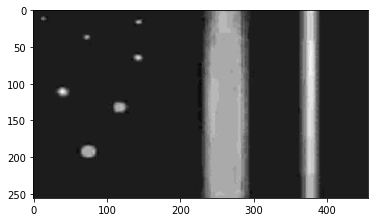

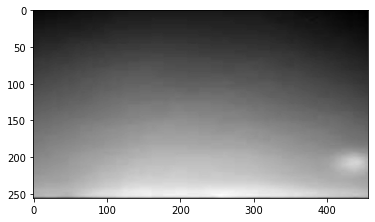

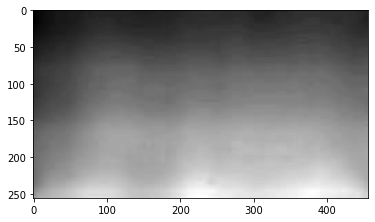

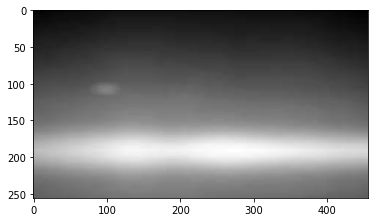

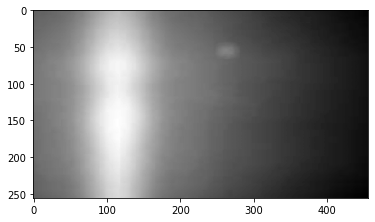

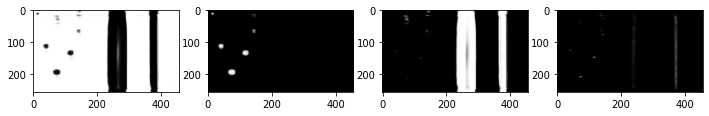

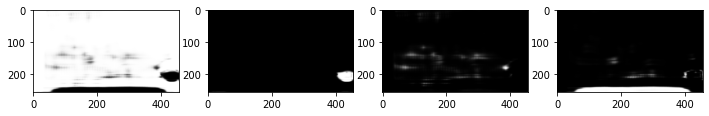

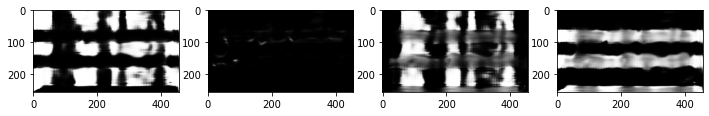

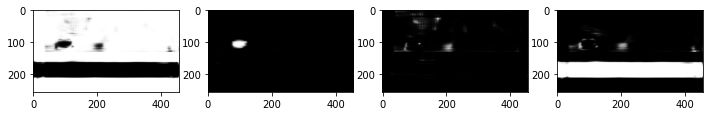

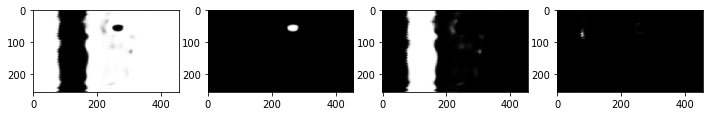

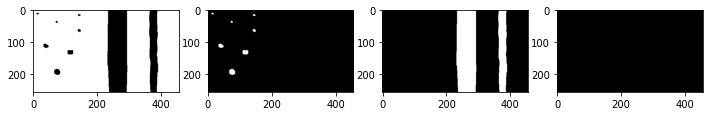

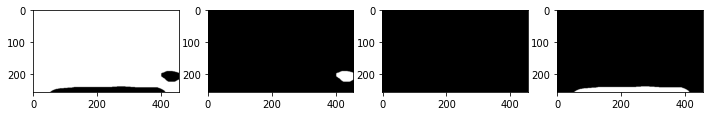

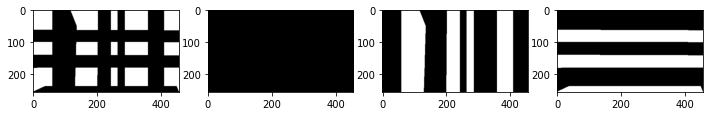

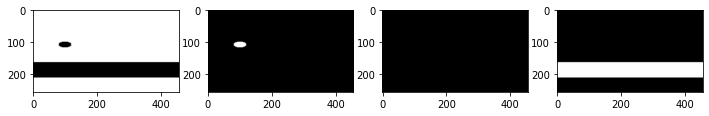

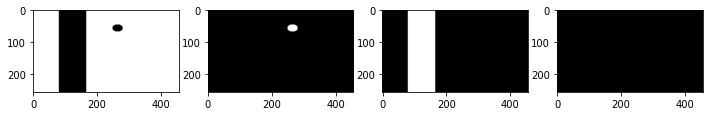

In [ ]:
img_input = x_data[0:5]
y_pred = model.predict(img_input)

# input img
plt.imshow(img_input[0, :, :, 0], cmap='gray')
plt.show()

plt.imshow(img_input[1, :, :, 0], cmap='gray')
plt.show()

plt.imshow(img_input[2, :, :, 0], cmap='gray')
plt.show()

plt.imshow(img_input[3, :, :, 0], cmap='gray')
plt.show()

plt.imshow(img_input[4, :, :, 0], cmap='gray')
plt.show()
print("======================================================================================")
# pred
fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    pred_mask = y_pred[0, :, :, i]
    ax[i].imshow(pred_mask, cmap='gray')  
plt.show()

fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    pred_mask = y_pred[1, :, :, i]
    ax[i].imshow(pred_mask, cmap='gray')  
plt.show()

fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    pred_mask = y_pred[2, :, :, i]
    ax[i].imshow(pred_mask, cmap='gray')  
plt.show()

fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    pred_mask = y_pred[3, :, :, i]
    ax[i].imshow(pred_mask, cmap='gray')  
plt.show()

fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    pred_mask = y_pred[4, :, :, i]
    ax[i].imshow(pred_mask, cmap='gray')  
plt.show()
print("======================================================================================")
# Truth
fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    y_truth = y_data[0, :, :, i]
    ax[i].imshow(y_truth, cmap='gray')  
plt.show()

fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    y_truth = y_data[1, :, :, i]
    ax[i].imshow(y_truth, cmap='gray')  
plt.show()

fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    y_truth = y_data[2, :, :, i]
    ax[i].imshow(y_truth, cmap='gray')  
plt.show()

fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    y_truth = y_data[3, :, :, i]
    ax[i].imshow(y_truth, cmap='gray')  
plt.show()

fig, ax = plt.subplots(1,4,figsize=(12,4))
for i in range(NUM_CLASSES):
    y_truth = y_data[4, :, :, i]
    ax[i].imshow(y_truth, cmap='gray')  
plt.show()

In [ ]:
# Loss_keypoint = []
# for i in history.history['loss']:
#   Loss_keypoint.append(i)

# accuracy_keypoint = []
# for i in history.history['accuracy']:
#   accuracy_keypoint.append(i)

# print(len(Loss_keypoint), len(accuracy_keypoint))

800 800


In [ ]:
for i in history.history['loss']:
  Loss_keypoint.append(i)

for i in history.history['accuracy']:
  accuracy_keypoint.append(i)
print(len(Loss_keypoint), len(accuracy_keypoint))

9000 9000


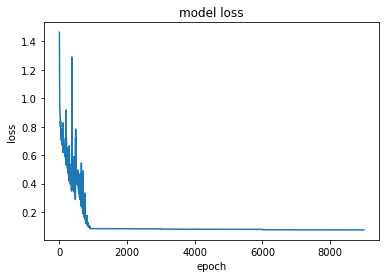

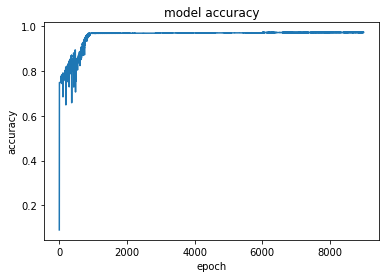

In [ ]:
plt.plot(Loss_keypoint)
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(accuracy_keypoint)
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.legend(['train', 'validation'], loc='upper left')
plt.show()